In [44]:
import os
import copy
import torch
import open_clip
import numpy as np
import pandas as pd
from torch import nn
from PIL import Image
import pickle as pkl
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from datasets import build_datasets

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dataset

Check `CUBDataset` and attributes

In [45]:
(dataset_train, dataset_val, dataset_test), attr_indices, class_attrs_df = build_datasets(
    dataset_dir=os.path.join('datasets', 'CUB'),
    attr_subset='cbm',
    use_class_level_attr=True,
    image_size=448
)

In [46]:
img_id, img, class_id, attrs = dataset_train[31]
print('img_id:', img_id, img_id.shape, img_id.dtype)
print('class_id:', class_id, class_id.shape, class_id.dtype)
print('attributes:', attrs, attrs.shape, attrs.dtype)
# img

img_id: tensor(1667) torch.Size([]) torch.int64
class_id: tensor(29) torch.Size([]) torch.int64
attributes: tensor([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0.]) torch.Size([112]) torch.float32


In [5]:
dataset.get_instance_attr_names(img_id, attrs)

,attr_name
10,has_wing_color::brown
25,has_upperparts_color::brown
40,has_underparts_color::brown
59,has_back_color::brown
80,has_upper_tail_color::brown
99,has_head_pattern::eyebrow
106,has_breast_color::brown
145,has_eye_color::black
153,has_forehead_color::brown
168,has_under_tail_color::brown


Load `CUBDataset` to `dataloader` and check

In [47]:
dataloader = DataLoader(dataset_test, batch_size=4, shuffle=True, num_workers=4)
dataloader_iter = iter(dataloader)

In [51]:
img_id, img, class_id, attrs = dataset_test[0]
print('img_id:', img_id, img_id.shape, img_id.dtype)
print('img:', img.shape, img_id.dtype)
print('class_id:', class_id, class_id.shape, class_id.dtype)
print('attributes:', attrs.shape, attrs.dtype)

img_id: tensor(0) torch.Size([]) torch.int64
img: torch.Size([3, 448, 448]) torch.int64
class_id: tensor(0) torch.Size([]) torch.int64
attributes: torch.Size([112]) torch.float32


In [40]:
img

tensor([[[0.0235, 0.0118, 0.0039,  ..., 0.0118, 0.0078, 0.0039],
         [0.0235, 0.0118, 0.0078,  ..., 0.0157, 0.0039, 0.0078],
         [0.0157, 0.0078, 0.0118,  ..., 0.0196, 0.0157, 0.0157],
         ...,
         [0.0196, 0.0118, 0.0078,  ..., 0.0039, 0.0039, 0.0078],
         [0.0314, 0.0157, 0.0039,  ..., 0.0039, 0.0078, 0.0078],
         [0.0471, 0.0196, 0.0000,  ..., 0.0118, 0.0157, 0.0118]],

        [[0.0039, 0.0000, 0.0039,  ..., 0.0078, 0.0118, 0.0118],
         [0.0118, 0.0039, 0.0000,  ..., 0.0039, 0.0039, 0.0078],
         [0.0196, 0.0118, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         ...,
         [0.0000, 0.0118, 0.0157,  ..., 0.0078, 0.0000, 0.0000],
         [0.0000, 0.0078, 0.0118,  ..., 0.0039, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.0000, 0.0078, 0.0196,  ..., 0.0039, 0.0000, 0.0000],
         [0.0157, 0.0157, 0.0157,  ..., 0.0039, 0.0078, 0.0235],
         [0.0235, 0.0196, 0.0118,  ..., 0.0078, 0.0196, 0.

In [56]:
img_id, img, class_id, attrs = next(dataloader_iter)

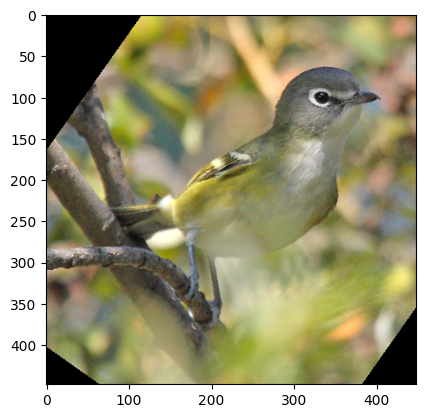

In [14]:
plt.imshow(img.squeeze().permute(1, 2, 0).numpy())
plt.show()

In [15]:
transforms = get_transforms()
dataset = CUBDataset(os.path.join('datasets', 'CUB'),
                     split='train',
                     use_class_level_attr=False,
                     transforms=transforms)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
dataloader_iter = iter(dataloader)

In [20]:
next(dataloader_iter)

[tensor([ 1379,  6127,  1165,  1990,  9079,  8960,   689,  4433,   426, 11432,
          3001,  9502,  2427,  9431,  4320, 10143]),
 tensor([[[[0.7569, 0.7647, 0.7725,  ..., 0.7608, 0.7529, 0.7529],
           [0.7255, 0.7333, 0.7412,  ..., 0.7647, 0.7569, 0.7529],
           [0.6745, 0.6863, 0.7020,  ..., 0.7608, 0.7569, 0.7569],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
          [[0.8745, 0.8784, 0.8902,  ..., 0.8902, 0.8824, 0.8824],
           [0.8510, 0.8549, 0.8627,  ..., 0.8902, 0.8902, 0.8824],
           [0.8078, 0.8157, 0.8275,  ..., 0.8941, 0.8902, 0.8902],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
          [[0.9569, 0.9608

# Model

In [10]:
from model import PartCEM
model = PartCEM()

In [14]:
a, b, c, d = model(torch.randn(4, 3, 448, 448))
print(a.shape, a.dtype)
print(b.shape, b.dtype)
print(c.shape, c.dtype)
print(d.shape, d.dtype)

torch.Size([4, 113, 28, 28]) torch.float32
torch.Size([4, 112]) torch.float32
torch.Size([4, 200]) torch.float32
torch.Size([]) torch.float32


In [16]:
torch.ones(4, 112).dtype

torch.float32